<a href="https://colab.research.google.com/github/Tanusri06/Brain-Tumor-VIT-Comparison/blob/main/notebooks/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import files

print("Please upload the kaggle.json file from your computer.")
files.upload()

Please upload the kaggle.json file from your computer.


Saving kaggle(1).json to kaggle(1).json


{'kaggle(1).json': b'{"username":"tanusric","key":"b25518ec837965f339c1335ca5ed0975"}'}

In [28]:
# (Optional) Rename the uploaded file to the standard 'kaggle.json'
# This helps avoid errors if you downloaded the key more than once.
# The quotes are important because of the space and parentheses.
!mv -f "kaggle(1).json" "kaggle.json"

# Create a directory to store the API key
!mkdir -p ~/.kaggle

# Move the key to that directory
!mv kaggle.json ~/.kaggle/

# Set the correct file permissions for the key
!chmod 600 ~/.kaggle/kaggle.json

# Now, download and unzip the specific dataset you chose
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 86% 128M/149M [00:00<00:00, 1.33GB/s]
100% 149M/149M [00:00<00:00, 569MB/s] 


In [29]:
!ls /content/dataset/Training

glioma	meningioma  notumor  pituitary


In [30]:
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [31]:
# --- Configuration ---
DATA_DIR = '/content/dataset/Training/'
TEST_DIR = '/content/dataset/Testing/' # The unseen data for final evaluation
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20 # You can adjust this number

# --- Data Loading Function ---
def load_data(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])

    df = pd.DataFrame({'filepath': image_paths, 'label': labels})
    return df, label_map

# --- Load and Split the Data ---
train_val_df, label_map = load_data(DATA_DIR)
test_df, _ = load_data(TEST_DIR)

# Split the main data into training and validation sets
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label']
)

print("Data loaded and split successfully:")
print(f"Label map: {label_map}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Data loaded and split successfully:
Label map: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training samples: 4569
Validation samples: 1143
Test samples: 1311


In [32]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformation for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transformation for validation and test data (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Custom PyTorch Dataset Class
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create the datasets
train_dataset = TumorDataset(train_df, transform=train_transform)
val_dataset = TumorDataset(val_df, transform=val_test_transform)
test_dataset = TumorDataset(test_df, transform=val_test_transform)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders are ready.")


DataLoaders are ready.


In [33]:
def train_model(model, model_name, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_accuracy = 0.0

    print(f"--- Starting Training for {model_name} ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\nEpoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_path = f'/content/{model_name}_best.pth'
            torch.save(model.state_dict(), save_path)
            print(f"----> New best model saved to {save_path}")

    print(f"\nFinished Training for {model_name}!")
    return best_val_accuracy

In [13]:
# --- Train Swin Transformer ---
swin_model_name = 'swin_base_patch4_window7_224'

# Create the Swin model using the 'timm' library
swin_model = timm.create_model(
    swin_model_name,
    pretrained=True,
    num_classes=len(label_map) # Set the output to our 4 classes
)
swin_model.to(device) # Move the model to the GPU

# Call the function you defined in the previous stage to start training
print(f"--- Starting Training for {swin_model_name} ---")
swin_accuracy = train_model(
    model=swin_model,
    model_name=swin_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

# Print the final result
print(f"\nBest Validation Accuracy for Swin Transformer: {swin_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

--- Starting Training for swin_base_patch4_window7_224 ---
--- Starting Training for swin_base_patch4_window7_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]


Validation Accuracy: 0.9361
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


Validation Accuracy: 0.9615
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9773
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]


Validation Accuracy: 0.9755

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


Validation Accuracy: 0.9834
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


Validation Accuracy: 0.9799

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9781

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Validation Accuracy: 0.9843
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]


Validation Accuracy: 0.9869
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9895
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9921
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9895

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9895

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9930
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9895

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]


Validation Accuracy: 0.9921

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9921

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


Validation Accuracy: 0.9948
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Validation Accuracy: 0.9886

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]

Validation Accuracy: 0.9895

Finished Training for swin_base_patch4_window7_224!

Best Validation Accuracy for Swin Transformer: 0.9948


In [14]:
# --- Train DeiT Model ---
deit_model_name = 'deit_base_patch16_224'

# Create the DeiT model from the 'timm' library
deit_model = timm.create_model(
    deit_model_name,
    pretrained=True,
    num_classes=len(label_map) # Set the output to our 4 classes
)
deit_model.to(device) # Move the model to the GPU

# Call the same training function, but with the new DeiT model
print(f"--- Starting Training for {deit_model_name} ---")
deit_accuracy = train_model(
    model=deit_model,
    model_name=deit_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

# Print the final result
print(f"\nBest Validation Accuracy for DeiT Transformer: {deit_accuracy:.4f}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

--- Starting Training for deit_base_patch16_224 ---
--- Starting Training for deit_base_patch16_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9458
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9676
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9668

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9729
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.47it/s]


Validation Accuracy: 0.9790
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9825
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.48it/s]


Validation Accuracy: 0.9825

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.48it/s]


Validation Accuracy: 0.9808

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9851
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.48it/s]


Validation Accuracy: 0.9781

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9851

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9860
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9851

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9834

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9843

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9746

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9869
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9860

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9860

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9886
----> New best model saved to /content/deit_base_patch16_224_best.pth

Finished Training for deit_base_patch16_224!

Best Validation Accuracy for DeiT Transformer: 0.9886


In [34]:
# Data Loading Function
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

# Load dataframes
train_val_df, label_map = load_data(DATA_DIR)
test_df, _ = load_data(TEST_DIR)

# Define Transformation
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df, self.transform = dataframe, transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create the Test DataLoader
test_dataset = TumorDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Test data is loaded and ready for evaluation.")

Test data is loaded and ready for evaluation.


In [35]:
def evaluate_model(model_name, test_loader, label_map):
    print(f"\n======================================================")
    print(f"   Starting Evaluation for: {model_name}")
    print(f"======================================================")

    model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{model_name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        print("Please make sure you have run the training for this model OR that the saved .pth file has been uploaded to /content/.")
        return

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(label_map.keys())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print("Accuracy:", accuracy_score(all_preds, all_labels))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

--- Starting Training for swin_tiny_patch4_window7_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.84it/s]


Validation Accuracy: 0.9291
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.38it/s]


Validation Accuracy: 0.9545
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.82it/s]


Validation Accuracy: 0.9423

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.18it/s]


Validation Accuracy: 0.9668
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.53it/s]


Validation Accuracy: 0.9703
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.67it/s]


Validation Accuracy: 0.9685

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:07<00:00,  5.09it/s]


Validation Accuracy: 0.9773
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.78it/s]


Validation Accuracy: 0.9781
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.16it/s]


Validation Accuracy: 0.9799
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.73it/s]


Validation Accuracy: 0.9808
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:07<00:00,  5.14it/s]


Validation Accuracy: 0.9886
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.73it/s]


Validation Accuracy: 0.9878

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:07<00:00,  5.06it/s]


Validation Accuracy: 0.9825

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.76it/s]


Validation Accuracy: 0.9860

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.15it/s]


Validation Accuracy: 0.9869

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.74it/s]


Validation Accuracy: 0.9799

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:07<00:00,  5.11it/s]


Validation Accuracy: 0.9895
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.75it/s]


Validation Accuracy: 0.9921
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.19it/s]


Validation Accuracy: 0.9878

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.78it/s]


Validation Accuracy: 0.9869

Finished Training for swin_tiny_patch4_window7_224!

   Starting Evaluation for: swin_tiny_patch4_window7_224


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 41/41 [00:07<00:00,  5.18it/s]



--- Evaluation Report for swin_tiny_patch4_window7_224 ---
Accuracy: 0.9908466819221968

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



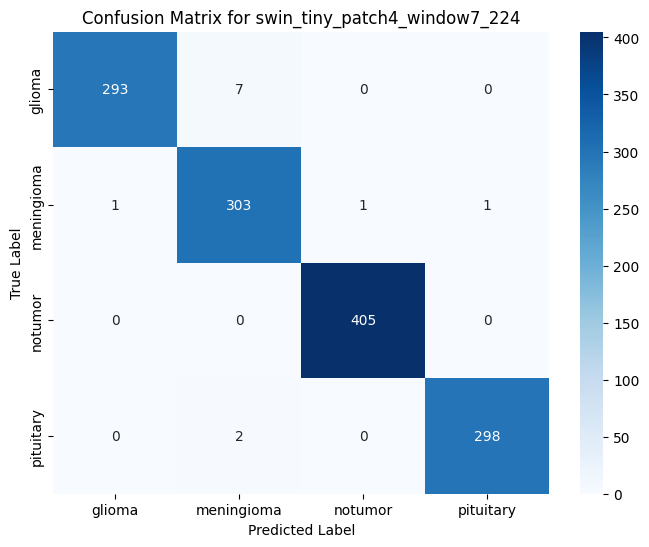

In [25]:
# --- Train and Evaluate Swin Transformer ---
swin_model_name = 'swin_tiny_patch4_window7_224'
swin_model = timm.create_model(swin_model_name, pretrained=True, num_classes=len(label_map))
swin_model.to(device)

# Train the model
train_model(swin_model, swin_model_name, train_loader, val_loader, EPOCHS, 1e-5)

# Immediately evaluate it on the test set
evaluate_model(swin_model_name, test_loader, label_map)

In [36]:
# --- Train DeiT Model ---
deit_model_name = 'deit_base_patch16_224'

# Create the DeiT model from the 'timm' library
deit_model = timm.create_model(
    deit_model_name,
    pretrained=True,
    num_classes=len(label_map) # Set the output to our 4 classes
)
deit_model.to(device) # Move the model to the GPU

# Call the same training function, but with the new DeiT model
print(f"--- Starting Training for {deit_model_name} ---")
deit_accuracy = train_model(
    model=deit_model,
    model_name=deit_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

# Print the final result
print(f"\nBest Validation Accuracy for DeiT Transformer: {deit_accuracy:.4f}")

--- Starting Training for deit_base_patch16_224 ---
--- Starting Training for deit_base_patch16_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.45it/s]


Validation Accuracy: 0.9501
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9746
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]


Validation Accuracy: 0.9799
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9825
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.48it/s]


Validation Accuracy: 0.9668

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9764

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9773

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9825

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9738

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9816

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9886
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.50it/s]


Validation Accuracy: 0.9895
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9834

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.47it/s]


Validation Accuracy: 0.9895

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.48it/s]


Validation Accuracy: 0.9895

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.47it/s]


Validation Accuracy: 0.9738

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9834

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Validation Accuracy: 0.9860

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.48it/s]


Validation Accuracy: 0.9571

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:14<00:00,  2.49it/s]

Validation Accuracy: 0.9851

Finished Training for deit_base_patch16_224!

Best Validation Accuracy for DeiT Transformer: 0.9895


In [1]:
def evaluate_model(model_name, test_loader, label_map):
    print(f"\n======================================================")
    print(f"   Starting Evaluation for: {model_name}")
    print(f"======================================================")

    model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{model_name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        print("Please make sure you have run the training for this model OR that the saved .pth file has been uploaded to /content/.")
        return

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(label_map.keys())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print("Accuracy:", accuracy_score(all_preds, all_labels))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()

In [3]:
# --- Train and Evaluate DeiT Transformer ---
deit_model_name = 'deit_tiny_patch16_224'
deit_model = timm.create_model(deit_model_name, pretrained=True, num_classes=len(label_map))
deit_model.to(device)

# Train the model
train_model(deit_model, deit_model_name, train_loader, val_loader, EPOCHS, 1e-5)

# Immediately evaluate it on the test set
evaluate_model(deit_model_name, test_loader, label_map)

NameError: name 'timm' is not defined